In [1]:
import os
import json
import h5py

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

from model_tf import ParT_Light

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# solve the problem of "libdevice not found at ./libdevice.10.bc"
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/home/r10222035/.conda/envs/tf2'

2025-08-21 17:28:56.112938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-21 17:28:56.585897: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Prepare the training samples

In [2]:
MAX_CONSTI = {
    'Jet': 50,
    'Tower': 250,
    'Track': 150,
    'Photon': 2,
    'Lepton': 4,
}

In [3]:
def prepare_feature_from_h5(h5_file, remove_photon=False):
    with h5py.File(h5_file, 'r') as f:
        event_pt = np.concatenate([f['TOWER/pt'][:], f['TRACK/pt'][:], f['PHOTON/pt'][:]], axis=1)
        event_eta = np.concatenate([f['TOWER/eta'][:], f['TRACK/eta'][:], f['PHOTON/eta'][:]], axis=1)
        event_phi = np.concatenate([f['TOWER/phi'][:], f['TRACK/phi'][:], f['PHOTON/phi'][:]], axis=1)
        event_mask = np.concatenate([f['TOWER/mask'][:], f['TRACK/mask'][:], np.tile([True, True], (event_pt.shape[0], 1))], axis=1)

        if remove_photon:
            photon_eta = f['PHOTON/eta'][:]
            photon_phi = f['PHOTON/phi'][:]
            indices = np.where((event_eta[:, :, None] == photon_eta[:, None, :]) & (event_phi[:, :, None] == photon_phi[:, None, :]))
            event_mask[indices[0], indices[1]] = False

        event_pt[event_mask == False] = float('nan')
        event_eta[event_mask == False] = float('nan')
        event_phi[event_mask == False] = float('nan')
        
        event_particle_type_0 = np.array([1] * MAX_CONSTI['Tower'] + [0] * MAX_CONSTI['Track'] + [0] * MAX_CONSTI['Photon'])
        event_particle_type_0 = np.tile(event_particle_type_0, (event_pt.shape[0], 1))
        event_particle_type_1 = np.array([0] * MAX_CONSTI['Tower'] + [1] * MAX_CONSTI['Track'] + [0] * MAX_CONSTI['Photon'])
        event_particle_type_1 = np.tile(event_particle_type_1, (event_pt.shape[0], 1))
        event_particle_type_2 = np.array([0] * MAX_CONSTI['Tower'] + [0] * MAX_CONSTI['Track'] + [1] * MAX_CONSTI['Photon'])
        event_particle_type_2 = np.tile(event_particle_type_2, (event_pt.shape[0], 1))

        features = np.stack([event_pt, event_eta, event_phi, event_particle_type_0, event_particle_type_1, event_particle_type_2], axis=-1)
    
    return features

In [4]:
def create_mix_sample_from(h5_dirs: list, nevents: tuple, ratios=(0.8, 0.2), seed=0):
    # h5_dirs: list of npy directories
    # nevents: tuple of (n_VBF_SR, n_VBF_BR, n_GGF_SR, n_GGF_BR)
    # ratios: tuple of (r_train, r_val)
    data_tr, data_vl, data_te = None, None, None
    label_tr, label_vl, label_te = None, None, None

    h5_dir0 = Path(h5_dirs[0])
    data_VBF_SR = prepare_feature_from_h5(h5_dir0 / 'VBF_in_SR.h5')
    data_VBF_BR = prepare_feature_from_h5(h5_dir0 / 'VBF_in_BR.h5')
    data_GGF_SR = prepare_feature_from_h5(h5_dir0 / 'GGF_in_SR.h5')
    data_GGF_BR = prepare_feature_from_h5(h5_dir0 / 'GGF_in_BR.h5')
    n_data_VBF_SR = data_VBF_SR.shape[0]
    n_data_VBF_BR = data_VBF_BR.shape[0]
    n_data_GGF_SR = data_GGF_SR.shape[0]
    n_data_GGF_BR = data_GGF_BR.shape[0]
    print(f'Number of events in VBF_SR: {n_data_VBF_SR}, VBF_BR: {n_data_VBF_BR}, GGF_SR: {n_data_GGF_SR}, GGF_BR: {n_data_GGF_BR}')

    n_VBF_SR, n_GGF_SR, n_VBF_BR, n_GGF_BR = nevents
    n_test = 10000
    n_VBF_SR_test = int(n_data_VBF_SR / (n_data_VBF_SR + n_data_VBF_BR) * n_test)
    n_VBF_BR_test = n_test - n_VBF_SR_test
    n_GGF_SR_test = int(n_data_GGF_SR / (n_data_GGF_SR + n_data_GGF_BR) * n_test)
    n_GGF_BR_test = n_test - n_GGF_SR_test

    r_tr, r_vl = ratios

    np.random.seed(seed)
    idx_VBF_SR = np.random.choice(n_data_VBF_SR, n_VBF_SR + n_VBF_SR_test, replace=False)
    idx_VBF_BR = np.random.choice(n_data_VBF_BR, n_VBF_BR + n_VBF_BR_test, replace=False)
    idx_GGF_SR = np.random.choice(n_data_GGF_SR, n_GGF_SR + n_GGF_SR_test, replace=False)
    idx_GGF_BR = np.random.choice(n_data_GGF_BR, n_GGF_BR + n_GGF_BR_test, replace=False)

    idx_VBF_SR_tr = idx_VBF_SR[:int(n_VBF_SR*r_tr)]
    idx_VBF_BR_tr = idx_VBF_BR[:int(n_VBF_BR*r_tr)]
    idx_GGF_SR_tr = idx_GGF_SR[:int(n_GGF_SR*r_tr)]
    idx_GGF_BR_tr = idx_GGF_BR[:int(n_GGF_BR*r_tr)]
    idx_VBF_SR_vl = idx_VBF_SR[int(n_VBF_SR*r_tr):n_VBF_SR]
    idx_VBF_BR_vl = idx_VBF_BR[int(n_VBF_BR*r_tr):n_VBF_BR]
    idx_GGF_SR_vl = idx_GGF_SR[int(n_GGF_SR*r_tr):n_GGF_SR]
    idx_GGF_BR_vl = idx_GGF_BR[int(n_GGF_BR*r_tr):n_GGF_BR]
    idx_VBF_SR_te = idx_VBF_SR[n_VBF_SR:]
    idx_VBF_BR_te = idx_VBF_BR[n_VBF_BR:]
    idx_GGF_SR_te = idx_GGF_SR[n_GGF_SR:]
    idx_GGF_BR_te = idx_GGF_BR[n_GGF_BR:]

    print(f'Preparing dataset from {h5_dirs}')
    for h5_dir in h5_dirs:

        h5_dir = Path(h5_dir)
        data_VBF_SR = prepare_feature_from_h5(h5_dir / 'VBF_in_SR.h5')
        data_VBF_BR = prepare_feature_from_h5(h5_dir / 'VBF_in_BR.h5')
        data_GGF_SR = prepare_feature_from_h5(h5_dir / 'GGF_in_SR.h5')
        data_GGF_BR = prepare_feature_from_h5(h5_dir / 'GGF_in_BR.h5')

        new_data_tr = np.concatenate([
            data_VBF_SR[idx_VBF_SR_tr],
            data_GGF_SR[idx_GGF_SR_tr],
            data_VBF_BR[idx_VBF_BR_tr],
            data_GGF_BR[idx_GGF_BR_tr]
        ], axis=0)
        new_data_vl = np.concatenate([
            data_VBF_SR[idx_VBF_SR_vl],
            data_GGF_SR[idx_GGF_SR_vl],
            data_VBF_BR[idx_VBF_BR_vl],
            data_GGF_BR[idx_GGF_BR_vl]
        ], axis=0)

        if data_tr is None:
            data_tr = new_data_tr
            data_vl = new_data_vl
        else:
            data_tr = np.concatenate([data_tr, new_data_tr], axis=0)
            data_vl = np.concatenate([data_vl, new_data_vl], axis=0)

        new_label_tr = np.zeros(new_data_tr.shape[0])
        new_label_tr[:idx_VBF_SR_tr.shape[0] + idx_GGF_SR_tr.shape[0]] = 1
        new_label_vl = np.zeros(new_data_vl.shape[0])
        new_label_vl[:idx_VBF_SR_vl.shape[0] + idx_GGF_SR_vl.shape[0]] = 1

        if label_tr is None:
            label_tr = new_label_tr
            label_vl = new_label_vl
        else:
            label_tr = np.concatenate([label_tr, new_label_tr])
            label_vl = np.concatenate([label_vl, new_label_vl])

    new_data_te = np.concatenate([
        data_VBF_SR[idx_VBF_SR_te],
        data_VBF_BR[idx_VBF_BR_te],
        data_GGF_SR[idx_GGF_SR_te],
        data_GGF_BR[idx_GGF_BR_te],
    ], axis=0)
    data_te = new_data_te

    new_label_te = np.zeros(new_data_te.shape[0])
    new_label_te[:n_test] = 1
    label_te = new_label_te

    return data_tr, data_vl, data_te, label_tr, label_vl, label_te


def create_pure_sample_from(h5_dir, n_events):

    h5_dir = Path(h5_dir)
    features_GGF = prepare_feature_from_h5(h5_dir / 'GGF.h5')
    features_VBF = prepare_feature_from_h5(h5_dir / 'VBF.h5')

    n_train, n_val, n_test = n_events
    
    # Split the dataset into training and validation sets
    X_train = np.concatenate([features_GGF[:n_train], features_VBF[:n_train]], axis=0)
    y_train = np.array([0] * n_train + [1] * n_train)
    X_val = np.concatenate([features_GGF[n_train:n_train+n_val], features_VBF[n_train:n_train+n_val]], axis=0)
    y_val = np.array([0] * n_val + [1] * n_val)
    X_test = np.concatenate([features_GGF[n_train+n_val:n_train+n_val+n_test], features_VBF[n_train+n_val:n_train+n_val+n_test]], axis=0)
    y_test = np.array([0] * n_test + [1] * n_test)

    return X_train, X_val, X_test, y_train, y_val, y_test


def compute_nevent_in_SR_BR(GGF_cutflow_file, VBF_cutflow_file, L, cut_type, BR=0.00227):
    # https://twiki.cern.ch/twiki/bin/view/LHCPhysics/CERNYellowReportPageAt14TeV
    cross_section_GGF = 54.67 * 1000
    cross_section_VBF = 4.278 * 1000

    GGF_selection = np.load(GGF_cutflow_file, allow_pickle=True).item()
    VBF_selection = np.load(VBF_cutflow_file, allow_pickle=True).item()

    if  cut_type == 'quark_jet_2':
        n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['two quark jet: sig region'] / GGF_selection['cutflow_number']['Total'] * BR * L
        n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['two quark jet: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR * L
        n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['two quark jet: sig region'] / VBF_selection['cutflow_number']['Total'] * BR * L
        n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['two quark jet: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR * L
    else:
        raise ValueError('cut_type must be mjj, deta, or mjj, or deta, or gluon_jet')
    return n_VBF_SR, n_GGF_SR, n_VBF_BR, n_GGF_BR

In [5]:
config_path = 'config_files/CWoLa_ParT_L100_remove_decay_products_config_01.json'

In [6]:
with open(config_path, 'r') as f:
    config = json.load(f)

npy_paths = config['npy_paths']
seed = config['seed']
model_name = config['model_name']
model_structure = config['model_structure']
training_method = config['training_method']
sample_type = config['sample_type']

In [7]:
if training_method == 'CWoLa':
    luminosity = config['luminosity']
    cut_type = config['cut_type']
    
    GGF_cutflow_file = config['GGF_cutflow_file']
    VBF_cutflow_file = config['VBF_cutflow_file']
    decay_channel = config['decay_channel']

    if decay_channel == 'ZZ4l':
        BR = 0.0001240
    elif decay_channel == 'aa':
        BR = 0.00227
    else:
        raise ValueError(f'Unknown decay channel: {decay_channel}')

    r_train, r_val = 0.8, 0.2
    n_SR_VBF, n_SR_GGF, n_BR_VBF, n_BR_GGF = compute_nevent_in_SR_BR(GGF_cutflow_file, VBF_cutflow_file, luminosity, cut_type, BR)
    n_events = (int(n_SR_VBF), int(n_SR_GGF), int(n_BR_VBF), int(n_BR_GGF))
    X_train, X_val, X_test, y_train, y_val, y_test = create_mix_sample_from(npy_paths, n_events, (r_train, r_val), seed=seed)
elif training_method == 'supervised':
    n_events = config['n_train'], config['n_val'], config['n_test']
    X_train, X_val, X_test, y_train, y_val, y_test = create_pure_sample_from(npy_paths[0], n_events)
else:
    raise ValueError(f'Unknown training method: {training_method}')

Number of events in VBF_SR: 286751, VBF_BR: 45436, GGF_SR: 78945, GGF_BR: 83384
Preparing dataset from ['../Sample/data/quark_jet_2_cut/pre-processing/']


In [ ]:
def pt_normalization(X):
    slices = [slice(0, 250), slice(250, 400), slice(400, 402)]
    for i, s in enumerate(slices):
        mean = np.nanmean(X[:, s, 0], axis=(1), keepdims=True)
        std = np.nanstd(X[:, s, 0], axis=(1), keepdims=True)
        epsilon = 1e-8
        std = np.where(std < epsilon, epsilon, std)

        X[:, s, 0] = (X[:, s, 0] - mean) / std

In [9]:
pt_normalization(X_train)
pt_normalization(X_val)
pt_normalization(X_test)

/tmp/ipykernel_1038654/4161501993.py:4: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(X[:, s, 0], axis=(1), keepdims=True)
/home/r10222035/.conda/envs/tf2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


array([[[-0.33462977, -4.55296469,  2.82812619,  1.        ,
          0.        ,  0.        ],
        [-0.34157268, -4.40323496, -1.99920964,  1.        ,
          0.        ,  0.        ],
        [-0.30885766, -4.0081315 , -0.64410949,  1.        ,
          0.        ,  0.        ],
        ...,
        [        nan,         nan,         nan,  0.        ,
          1.        ,  0.        ],
        [ 1.        ,  0.03354176,  1.78497815,  0.        ,
          0.        ,  1.        ],
        [-1.        ,  1.46319485,  1.34313703,  0.        ,
          0.        ,  1.        ]],

       [[-0.27303591, -4.43109226,  0.75417924,  1.        ,
          0.        ,  0.        ],
        [-0.26920346, -0.24683785, -2.50595474,  1.        ,
          0.        ,  0.        ],
        [-0.25970001,  0.12783797, -0.89452958,  1.        ,
          0.        ,  0.        ],
        ...,
        [        nan,         nan,         nan,  0.        ,
          1.        ,  0.        ],
  

In [10]:
def get_sample_size(y):
    if len(y.shape) == 1:
        ns = (y == 1).sum()
        nb = (y == 0).sum()
    else:
        ns = (y.argmax(axis=1) == 1).sum()
        nb = (y.argmax(axis=1) == 0).sum()
    print(f'Sample size: ns = {ns}, nb = {nb}')
    return ns, nb

In [11]:
train_size = get_sample_size(y_train)
val_size = get_sample_size(y_val)
test_size = get_sample_size(y_test)

class_weight = {0: 1.0, 1: train_size[1] / train_size[0]}

Sample size: ns = 720, nb = 491
Sample size: ns = 180, nb = 124
Sample size: ns = 10000, nb = 10000


In [12]:
# Training parameters
with open('params.json', 'r') as f:
    params = json.load(f)

BATCH_SIZE = params['BATCH_SIZE']
EPOCHS = params['EPOCHS']
patience = params['patience']
min_delta = params['min_delta']
learning_rate = params['learning_rate']

save_model_name = f'./ParT_models/last_model/'

In [13]:
with tf.device('CPU'):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(y_train)).batch(BATCH_SIZE)
    # del X_train, y_train

    valid_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    valid_dataset = valid_dataset.batch(BATCH_SIZE)

2025-08-21 17:31:43.804415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-21 17:31:45.052265: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


# Model

In [14]:
class MyTestingCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        super(MyTestingCallback, self).__init__()
        self.test_data = test_data
        self.testing_loss = []
        self.testing_accuracy = []
        self.testing_auc = []

    def on_epoch_end(self, epoch, logs=None):
        # Test on another dataset
        results = self.model.evaluate(x=self.test_data[0], y=self.test_data[1], batch_size=BATCH_SIZE)
        self.testing_loss.append(results[0])
        print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

        # Compute ACC
        y_pred = self.model.predict(self.test_data[0], batch_size=BATCH_SIZE)
        ACC = get_highest_accuracy(self.test_data[1], y_pred)
        self.testing_accuracy.append(ACC)
        print(f'True ACC: Testing Loss = {results[0]:.3}, Testing Accuracy = {ACC:.3}')

        # Compute AUC
        fpr, tpr, _ = roc_curve(self.test_data[1], y_pred)
        AUC = roc_auc_score(self.test_data[1], y_pred)
        if AUC < 0.5:
            AUC = 1 - AUC
        self.testing_auc.append(AUC)
        print(f'True AUC: Testing Loss = {results[0]:.3}, Testing AUC = {AUC:.3}')


def get_highest_accuracy(y_true, y_pred):
    _, _, thresholds = roc_curve(y_true, y_pred)
    # compute highest accuracy
    thresholds = np.array(thresholds)
    if len(thresholds) > 1000:
        thresholds = np.percentile(thresholds, np.linspace(0, 100, 1001))
    accuracy_scores = []
    for threshold in thresholds:
        accuracy_scores.append(accuracy_score(y_true, y_pred>threshold))

    accuracies = np.array(accuracy_scores)
    return accuracies.max()


class ROCCallback(tf.keras.callbacks.Callback):
    def __init__(self, testing_data):
        super(ROCCallback, self).__init__()
        self.testing_data = testing_data
        self.save_path = './figures/HVmodel_roc_curve'
    
    def set_save_path(self, path):
        self.save_path = path

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            val_loss = logs.get('val_loss')
            print(f'Validation loss at epoch {epoch}: {val_loss:.3f}')

            x_test, y_test = self.testing_data
            y_pred = self.model.predict(x_test)
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred)
            
            # plot ROC curve
            fig, ax = plt.subplots(1,1, figsize=(5,4))
            ax.plot(fpr, tpr, label=f'AUC = {auc:.3f}, Loss = {val_loss:.3f}')
            ax.plot([0, 1], [0, 1], 'k--')

            ax.axvline(x=0.1, color='grey', linestyle='--', linewidth=1)
            ax.axvline(x=0.01, color='grey', linestyle='--', linewidth=1)
            ax.axvline(x=0.001, color='grey', linestyle='--', linewidth=1)

            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'ROC curve - Epoch {epoch+1}')
            ax.legend(frameon=False, fontsize=9)

            plt.savefig(f'{self.save_path}_ep{epoch+1}.pdf', dpi=300, facecolor='White', bbox_inches='tight')
            plt.close(fig)


class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [15]:
test_data = [X_test, y_test]
testing_callback = MyTestingCallback(test_data)
loss_history = LossHistory()

In [16]:
# Create model
model = ParT_Light(num_channels=3)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, verbose=1, patience=patience)
check_point = tf.keras.callbacks.ModelCheckpoint(save_model_name, monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(train_dataset, validation_data=valid_dataset, epochs=EPOCHS, class_weight=class_weight,
                    callbacks=[early_stopping,
                               check_point,
                               testing_callback,
                               loss_history,
                            #    roc_callback,
                               ]
                    )


Epoch 1/500


2025-08-21 17:32:38.903847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2025-08-21 17:32:38.920715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-08-21 17:32:39.580629: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f8348044df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-21 17:32:39.580673: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-08-21 17:32:39.588268: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-21 17:32:40.196586: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of 

3/3 [==============================] - ETA: 0s - loss: 5.6386 - accuracy: 0.5186
Epoch 1: val_loss improved from inf to 6.22008, saving model to ./ParT_models/last_model/
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f86482deb20>, 140216321798448), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f864828f280>, 140216321798832), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f86482b2190>, 140216321893296), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.fun

INFO:tensorflow:Assets written to: ./ParT_models/last_model/assets


INFO:tensorflow:Assets written to: ./ParT_models/last_model/assets


40/40 [==============================] - 16s 133ms/step - loss: 7.6246 - accuracy: 0.5000
Testing Loss = 7.62, Testing Accuracy = 0.5
40/40 [==============================] - 15s 129ms/step
True ACC: Testing Loss = 7.62, Testing Accuracy = 0.514
True AUC: Testing Loss = 7.62, Testing AUC = 0.501
3/3 [==============================] - 220s 62s/step - loss: 5.6386 - accuracy: 0.5186 - val_loss: 6.2201 - val_accuracy: 0.5921
Epoch 2/500
3/3 [==============================] - ETA: 0s - loss: 6.1828 - accuracy: 0.5945
Epoch 2: val_loss did not improve from 6.22008
40/40 [==============================] - 5s 132ms/step - loss: 7.6246 - accuracy: 0.5000
Testing Loss = 7.62, Testing Accuracy = 0.5
40/40 [==============================] - 5s 128ms/step
True ACC: Testing Loss = 7.62, Testing Accuracy = 0.506
True AUC: Testing Loss = 7.62, Testing AUC = 0.549
3/3 [==============================] - 36s 18s/step - loss: 6.1828 - accuracy: 0.5945 - val_loss: 6.2201 - val_accuracy: 0.5921
Epoch 3/500

KeyboardInterrupt: 

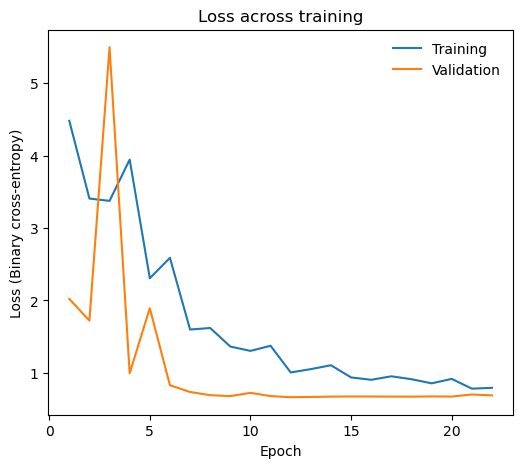

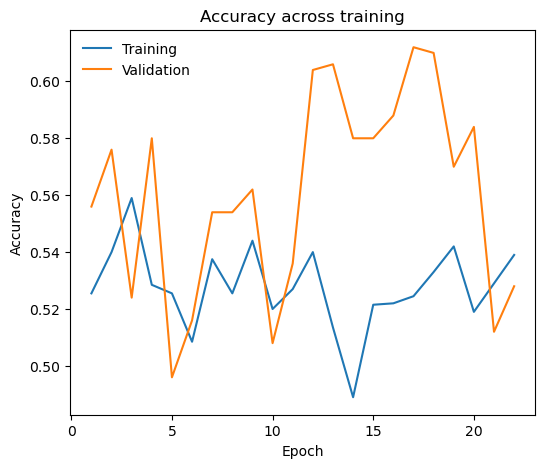

In [21]:
fig, ax = plt.subplots(1,1, figsize=(6, 5))

x = range(1, len(history.history['loss']) + 1)
y_train = history.history['loss']
y_validation = history.history['val_loss']

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')

ax.set_title('Loss across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (Binary cross-entropy)')
ax.legend(frameon=False)

plt.show()

fig, ax = plt.subplots(1,1, figsize=(6, 5))

x = range(1, len(history.history['accuracy']) + 1)
y_train = history.history['accuracy']
y_validation = history.history['val_accuracy']

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')

ax.set_title('Accuracy across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(frameon=False)

plt.show()


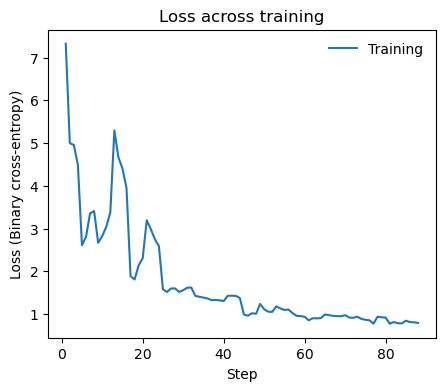

In [22]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

x = range(1, len(loss_history.losses) + 1)
y_train = loss_history.losses
# y_validation = history.history['val_loss']

ax.plot(x, y_train, label='Training')
# ax.plot(x, y_validation, label='Validation')

ax.set_title('Loss across training')
# ax.set_xlim(1000, 3000)
ax.set_xlabel('Step')
ax.set_ylabel('Loss (Binary cross-entropy)')
ax.legend(frameon=False)

plt.show()

# Training results

## Model

In [23]:
save_model_name = f'./ParT_models/last_model/'

loaded_model = tf.keras.models.load_model(save_model_name)

## Testing data

In [24]:
results = loaded_model.evaluate(x=X_test, y=y_test)
print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

16/16 [==============================] - 1s 26ms/step - loss: 0.6726 - accuracy: 0.5900
Testing Loss = 0.673, Testing Accuracy = 0.59


16/16 [==============================] - 1s 25ms/step


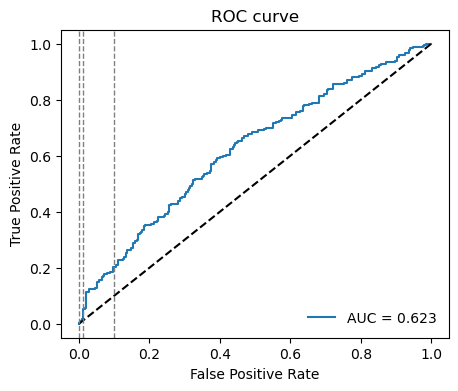

In [25]:
# Plot ROC curve
y_pred = loaded_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

fig, ax = plt.subplots(1,1, figsize=(5,4))
ax.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
ax.plot([0, 1], [0, 1], 'k--')

ax.axvline(x=0.1, color='grey', linestyle='--', linewidth=1)
ax.axvline(x=0.01, color='grey', linestyle='--', linewidth=1)
ax.axvline(x=0.001, color='grey', linestyle='--', linewidth=1)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve')
ax.legend(frameon=False)

plt.show()